# Проект №3 EDA + Feature Engineering Booking.com

# Признаки

hotel_address - адрес отеля
review_date - дата, когда рецензент разместил соответствующий отзыв.
average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
hotel_name - название отеля
reviewer_nationality - национальность рецензента
negative_review - отрицательный отзыв, который рецензент дал отелю.
review_total_negative_word_counts - общее количество слов в отрицательном отзыв
positive_review - положительный отзыв, который рецензент дал отелю
review_total_positive_word_counts - общее количество слов в положительном отзыве
reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
total_number_of_reviews - общее количество действительных отзывов об отеле
tags - теги, которые рецензент дал отелю.
days_since_review - продолжительность между датой проверки и датой очистки
additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
lat - широта отеля
lng - долгота отеля

# Файлы для соревнования

hotels_train.csv - набор данных для обучения

hotels_test.csv - набор данных для оценки качества

submission.csv - файл сабмишна 

## 0. Вводные данные

In [93]:
import pandas as pd
import numpy as np
import time
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
import collections
import category_encoders as ce
from sklearn.feature_selection import chi2 
from sklearn.feature_selection import f_classif 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor  
from collections import Counter
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hkd/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [94]:
RANDOM_SEED = 42 #фиксируем RANDOM_SEED для воспроизводства эксперимента

In [95]:
df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # сабмишн

# 1. Первичная очистка

In [97]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [98]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [99]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [100]:
df_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [101]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [102]:
sample_submission.head(3)

,reviewer_score,id
0,8.423,488440
1,7.075,274649
2,8.327,374688


In [103]:
# найдем дубликаты
mask = df_train.duplicated(subset=df_train.columns) # маска для фильтрации
data_duplicates = df_train[mask] # фильтруем наш датасет
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 307


In [104]:
# удалим дубликаты
df_train.drop_duplicates(inplace=True)

In [105]:
# объединим данные
df_train['sample'] = 1 # данные для обучения
df_train['id'] = df_train.index
df_test['sample'] = 0 # данные для теста
df_test['reviewer_score'] = 0 # заполним нулями тестовые данные для предсказания
df_test['id'] = df_test.index # зададим id в тестовых данных
data = df_train.copy()
data = pd.concat([df_train,df_test],axis=0,ignore_index=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [106]:
# исследуем данные на наличие пропусков
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_with_null

lat    0.634032
lng    0.634032
dtype: float64

In [107]:
# поскольку привязка отеле к широте и долготе при выборе не является существенной, удалим данные.
data.drop(['lat', 'lng'], axis=1, inplace=True)

# 2. Разработка признаков

In [108]:
#Для информации выведем количество уникальных значений в каждом признаке
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
reviewer_score                                    38
tags                                           55242
days_since_review                                731
sample                                             2
id                                            386521
dtype: int64

In [109]:
# проанализируем позитивные и негативные отзывы с помощью SentimentIntensityAnalyzer. 
# Результаты занесем в отдельные признаки. Исходные признаки удалим.
sent_analyzer = SentimentIntensityAnalyzer()
start_time = time.time()
pos = data["positive_review"].apply(lambda x: abs(sent_analyzer.polarity_scores(x)["compound"]))
neg = data["negative_review"].apply(lambda x: -abs(sent_analyzer.polarity_scores(x)["compound"]))

data["sentiment_score"] = pos + neg
data["polarity_pos"] = pos
data["polarity_neg"] = neg

time_model = time.time() - start_time
print(f"Execution time: {int(time_model)} seconds")

data.drop(['positive_review', 'negative_review'], axis=1, inplace=True)

data.info()

Execution time: 202 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  int64  
 8   review_total_positive_word_counts           515431 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given

In [110]:
# Преобразуем функции «days_since_review» в хронологический порядок 
data['days_since_review'] \
    = data['days_since_review'].apply(lambda x: int(x.split()[0]))
data['day_number'] \
    = (data['days_since_review']-data['days_since_review'].max()) * (-1)

In [111]:
# извлечем из адреса страну и город отеля и запишем в новый признак. 
# добавим данные о количестве населения и площади города в отдельные признаки. Удалим исходный признак.
data['hotel_city'] = data['hotel_address'].apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])

сity_population = {
    'Paris':  2148327, 'London': 8908081, 'Milan': 1366180, 
    'Vienna': 1911191, 'Barcelona': 1636732, 'Amsterdam': 860124
}
сity_area = {
    'Paris': 105, 'London': 1706, 'Milan': 181, 
    'Vienna': 414, 'Barcelona': 101, 'Amsterdam': 219
}

data['сity_population'] = data['hotel_city'].map(сity_population)
data['сity_area'] = data['hotel_city'].map(сity_area)

data.drop(['hotel_address'], axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   review_date                                 515431 non-null  object 
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   review_total_positive_word_counts           515431 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 9   reviewer_score                              515431 non-null  float64
 

In [112]:
# Преобразуем  признак даты в datetime
data['review_date'] = pd.to_datetime(data['review_date'])
# Создадим новые признаки
data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month
data.drop(['review_date'], axis=1, inplace=True)

In [113]:
# уменьшим количество значений reviewer_nationality создав признак other
# удалим лишние пробелы
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.replace(' ', ''))
# создадим список 25 самых популярных национальностей
top25_reviewer_nationality = data['reviewer_nationality'].value_counts().nlargest(25).index.to_list()
# создадим признак
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top25_reviewer_nationality else 'Other')
data['reviewer_nationality'].value_counts()

UnitedKingdom            245165
Other                     75745
UnitedStatesofAmerica     35390
Australia                 21663
Ireland                   14820
UnitedArabEmirates        10230
SaudiArabia                8945
Netherlands                8762
Switzerland                8672
Germany                    7936
Canada                     7887
France                     7277
Israel                     6604
Italy                      6113
Belgium                    6027
Turkey                     5441
Kuwait                     4918
Spain                      4735
Romania                    4549
Russia                     3898
SouthAfrica                3820
India                      3434
Greece                     3401
China                      3398
Sweden                     3366
NewZealand                 3235
Name: reviewer_nationality, dtype: int64

In [114]:
# теги
# преобразование строковых переменных в списки.
data['tags'] = data['tags'].apply(lambda x: x[3:-3].split(' \', \' '))

In [115]:
# получим продолжительности пребывания.
# заполним значений NaN типичной продолжительностью пребывания в 1 день.
def get_stay(x):
    for tag in x:
        words = tag.split()
        if words[0] =='Stayed':
            return int(words[1])
    return np.NaN

data['stay'] = data['tags'].apply(get_stay)
data['stay'].fillna(1, inplace=True)

In [116]:
# запустим кодирование для наиболее частых тегов. 
# наиболее часто берется 5% от размера набора данных.
boundary = data.shape[0] * 0.05  # 5% граница
c = Counter(tag for row in data['tags'] for tag in row)
frequent_tags_count = dict(filter(lambda x: x[1] > boundary, c.items()))
print('Наиболее часто встречающиеся теги и их количество:')
frequent_tags_count


Наиболее часто встречающиеся теги и их количество:


{'Leisure trip': 417538,
 'Couple': 252128,
 'Stayed 2 nights': 133850,
 'Submitted from a mobile device': 307470,
 'Business trip': 82884,
 'Standard Double Room': 32247,
 'Stayed 1 night': 193568,
 'Solo traveler': 108476,
 'Stayed 3 nights': 95761,
 'Superior Double Room': 31361,
 'Stayed 4 nights': 47777,
 'Double Room': 35207,
 'Family with young children': 60989,
 'Group': 65361,
 'Family with older children': 26334}

In [117]:
# получим список наиболее часто встречающихся тегов
frequent_tags = list(dict(filter(lambda x: 
    x[1]>boundary and x[0].split()[0]!='Stayed',
    frequent_tags_count.items())).keys())
frequent_tags

['Leisure trip',
 'Couple',
 'Submitted from a mobile device',
 'Business trip',
 'Standard Double Room',
 'Solo traveler',
 'Superior Double Room',
 'Double Room',
 'Family with young children',
 'Group',
 'Family with older children']

In [118]:
# выполним быстрое кодирование для частых тегов
for tag in frequent_tags:
    data[tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)

In [119]:
# произведем кодировку признака hotel_name методом двоичного кодирования, тк количество значений более 1400 
# удалим исходный признак.
bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['hotel_name'], axis=1, inplace=True)


In [120]:
# выделим признаки, которые можно быстро закодировать с помощью get_dummies.
to_get_dummies = ['hotel_city', 'reviewer_nationality']
data = pd.get_dummies(data, columns=to_get_dummies)

In [121]:
# проверим, какие признаки типа object остались в наших данных.
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
object_columns

['tags']

In [122]:
# удалим оставшийся отработанный признак
data.drop(['tags'], axis=1, inplace=True)

# 3. Мультиколлинеарность

In [123]:
# Создаем дубликат базы
data_copy = data.copy()

In [124]:
# Выводим оставшиеся признаки
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 73 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   reviewer_score                              515431 non-null  float64
 7   days_since_review                           515431 non-null  int64  
 8   sample                                      515431 non-null  int64  
 9   id                                          515431 non-null  int64  
 

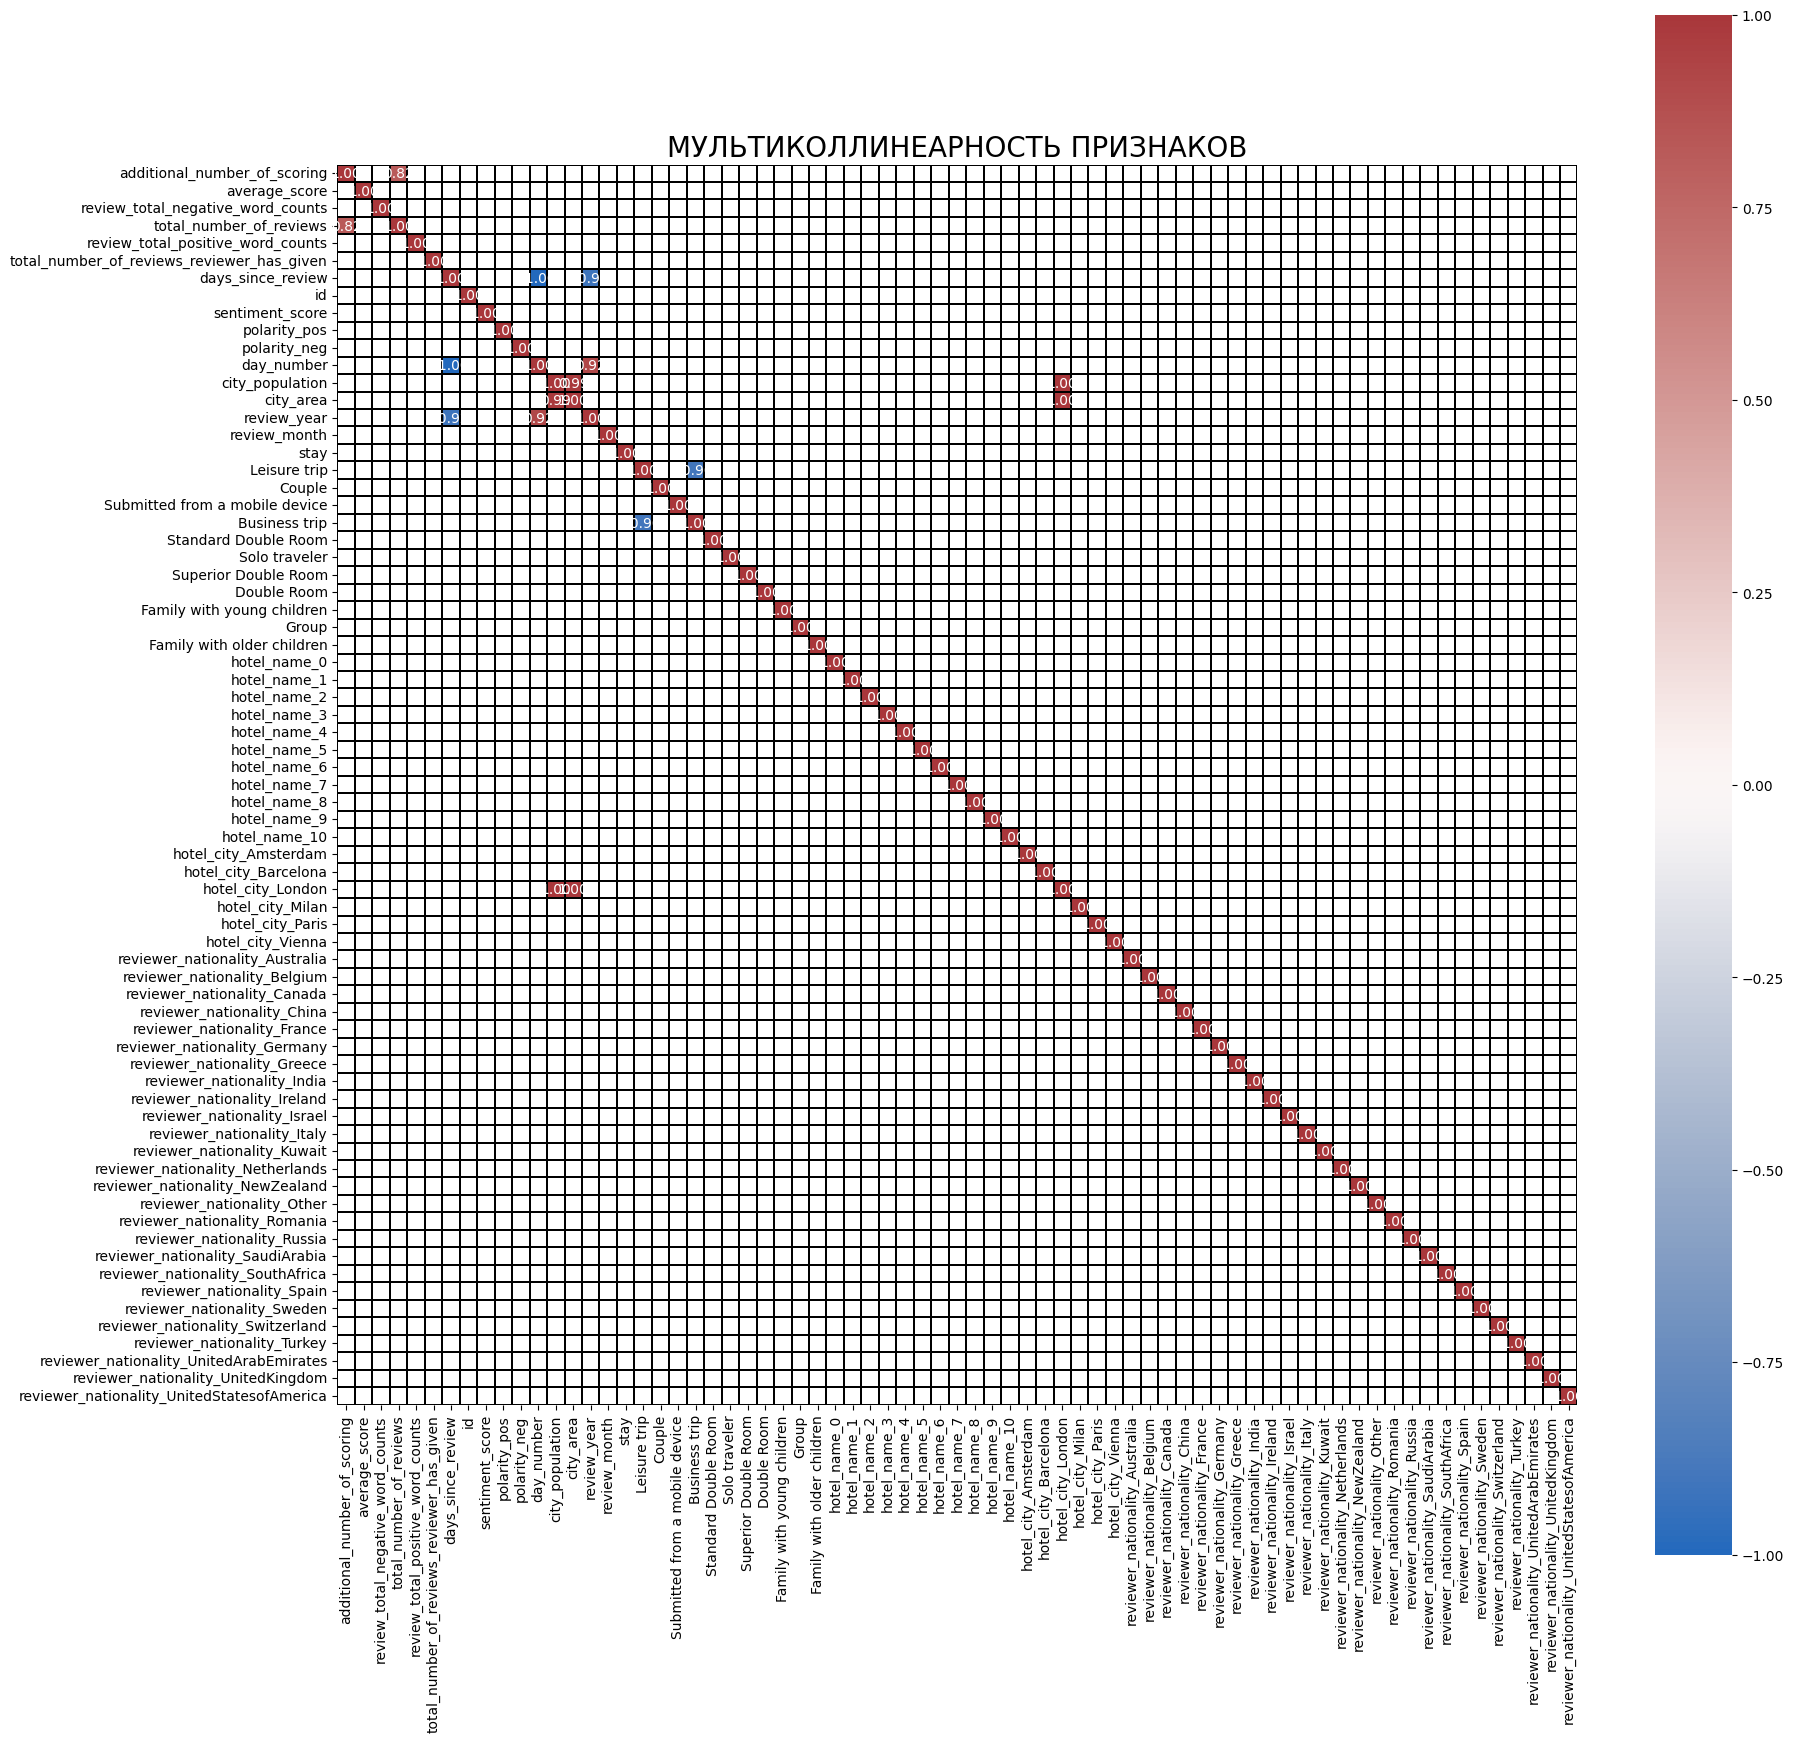

In [125]:
# Построим тепловую корреляционную матрицу и проанализируем данные на наличие мультиколлинеарности
# Данные для построения графика
corr = data_copy.drop(['reviewer_score', 'sample'], axis=1).corr()
plt.subplots(figsize=(20, 20))
# тепловая матрица с коэффициентами корреляции не менее 0.7
ax_heat_multicoll = sns.heatmap(
    corr[corr.abs() >= 0.7], 
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='black', 
    cmap='vlag',
    annot = True,
    fmt='.2f',
    square=True
)

ax_heat_multicoll.set_title('МУЛЬТИКОЛЛИНЕАРНОСТЬ ПРИЗНАКОВ', fontsize=20);

In [126]:
# в парах с высокой мультиколлинеарностью удаляем 'additional_number_of_scoring', 'City_population', 'review_year', 'hotel_city_London'
# в результате остается day_since_review'
# оставляем один признак поездки 'leisure trip'
# также оставляем пару day_since_review' и 'day_number' 
data_copy.drop([
    'Business trip', 'additional_number_of_scoring', 
    'сity_population', 'review_year', 'hotel_city_London'], 
    axis=1, inplace=True)

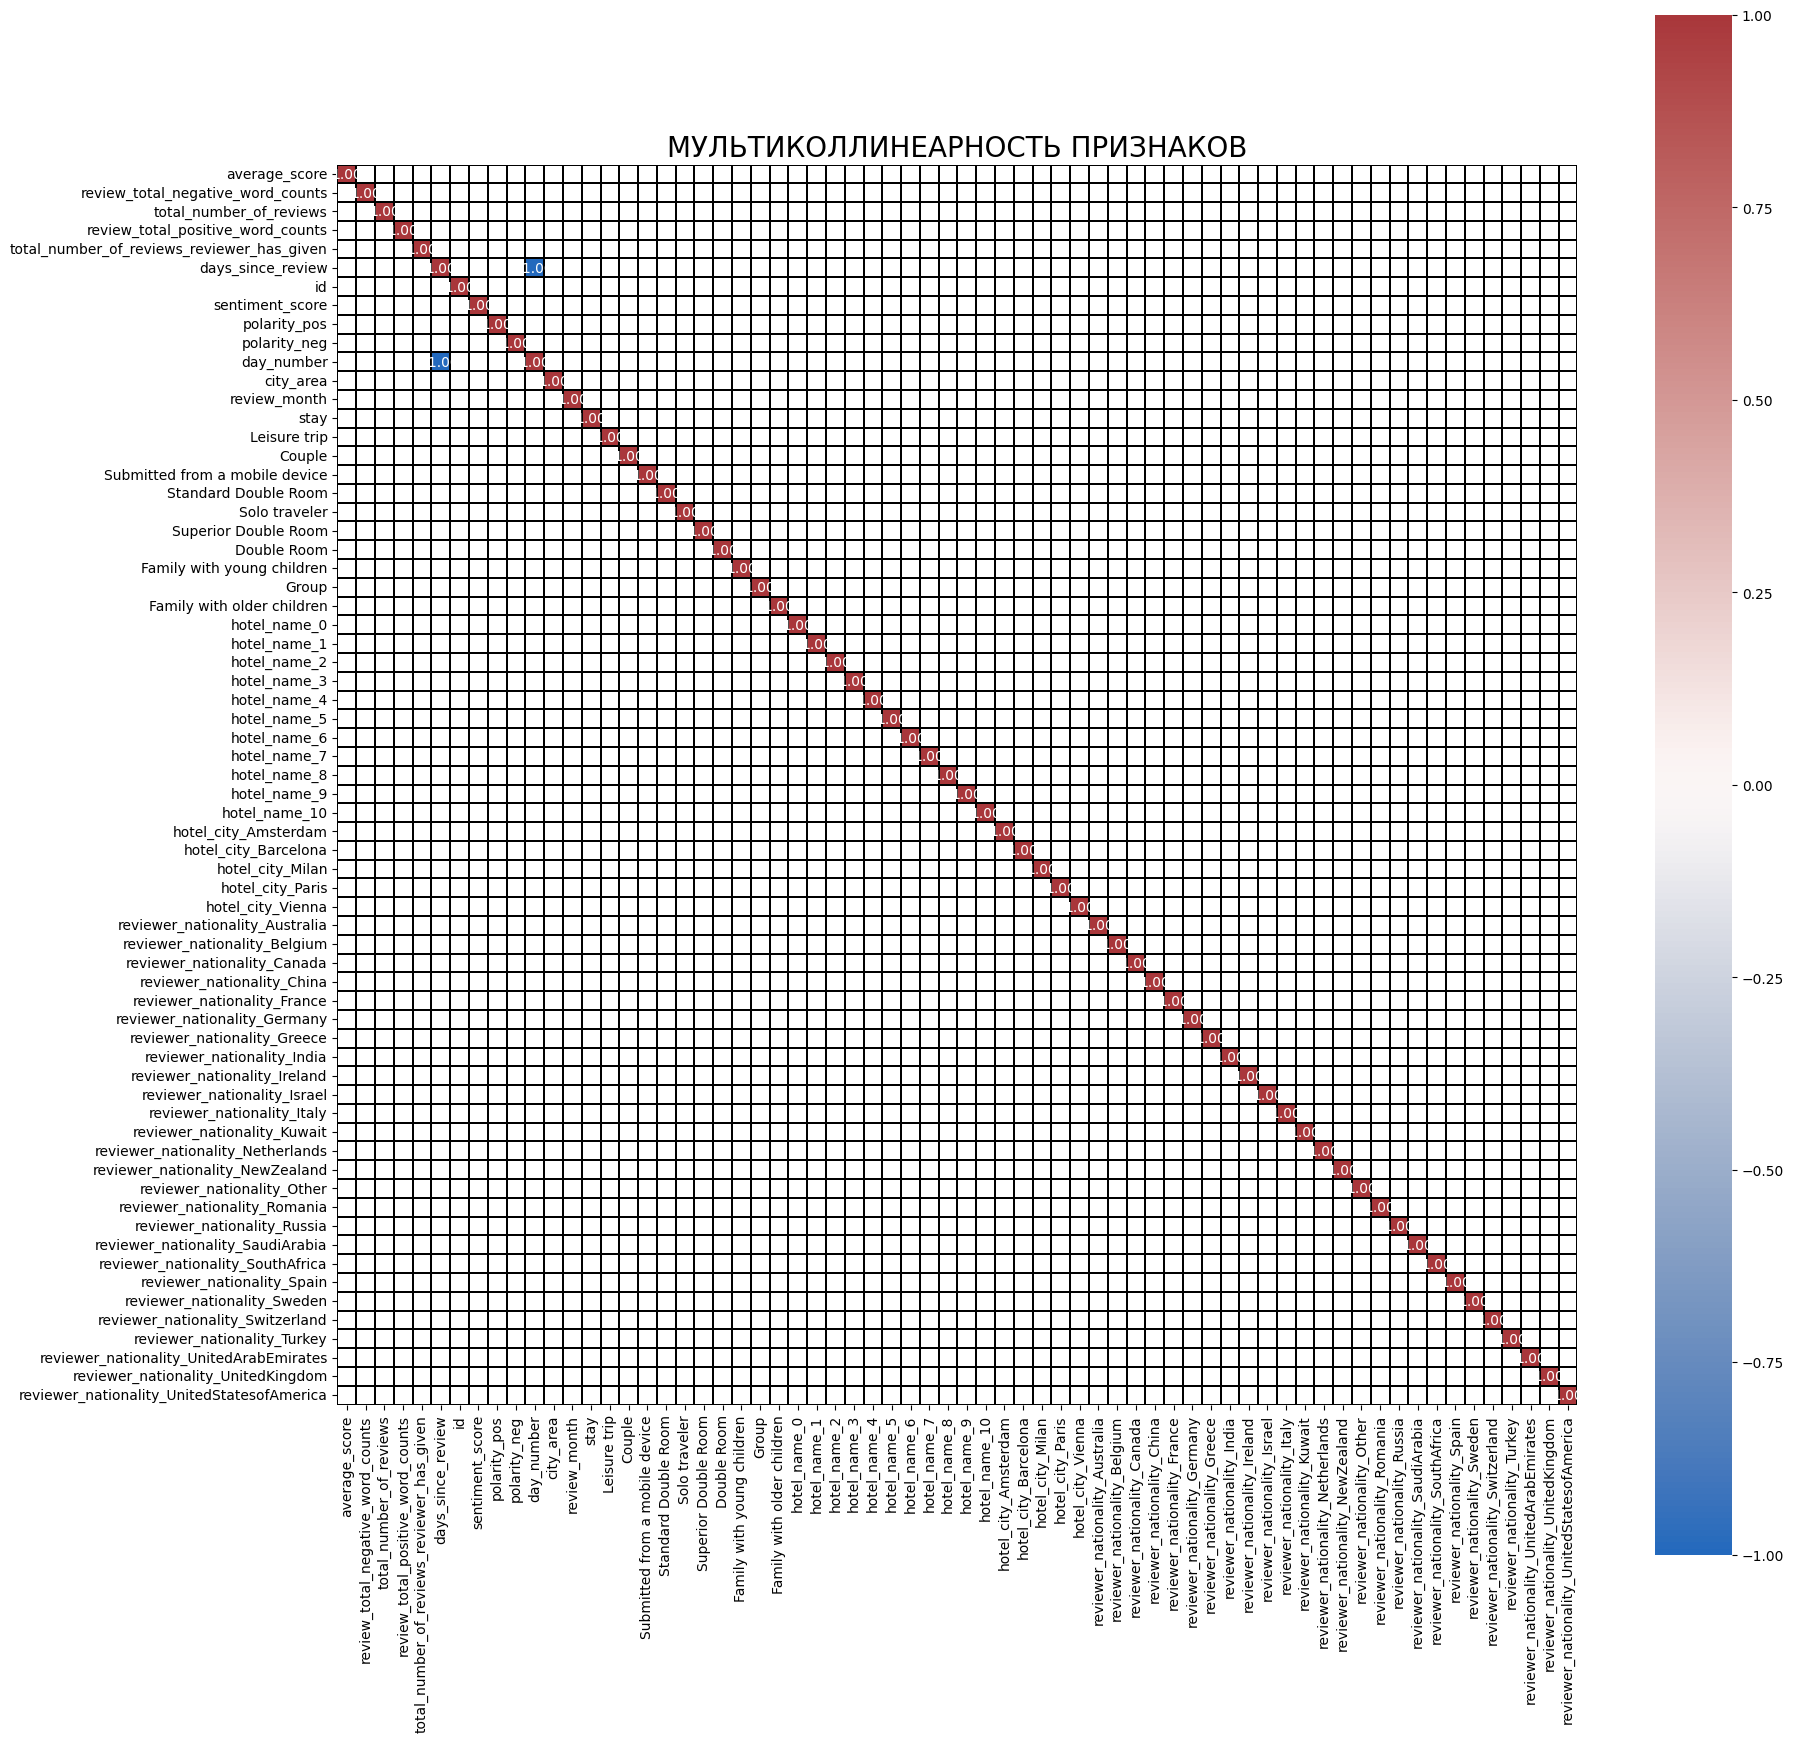

In [127]:
# проверяем корреляцию
corr = data_copy.drop(['reviewer_score', 'sample'], axis=1).corr()
plt.subplots(figsize=(20, 20))
# тепловая матрица с коэффициентами корреляции не менее 0.7
ax_heat_multicoll = sns.heatmap(
    corr[corr.abs() >= 0.7], 
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='black', 
    cmap='vlag',
    annot = True,
    fmt='.2f',
    square=True
)

ax_heat_multicoll.set_title('МУЛЬТИКОЛЛИНЕАРНОСТЬ ПРИЗНАКОВ', fontsize=20);

# 4. Нормализация и выбор признаков

In [128]:
# Выводим оставшиеся признаки
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 68 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515431 non-null  float64
 1   review_total_negative_word_counts           515431 non-null  int64  
 2   total_number_of_reviews                     515431 non-null  int64  
 3   review_total_positive_word_counts           515431 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 5   reviewer_score                              515431 non-null  float64
 6   days_since_review                           515431 non-null  int64  
 7   sample                                      515431 non-null  int64  
 8   id                                          515431 non-null  int64  
 9   sentiment_score                             515431 non-null  float64
 

In [133]:
# непрерывные признаки
num_cols = ['average_score', 'sentiment_score', 'polarity_pos', 'polarity_neg', 
            'total_number_of_reviews', 'review_total_negative_word_counts', 
            'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given',
            'days_since_review', 
            'сity_area', 'day_number']

# категориальные признаки
cat_cols = ['review_month','stay', 'hotel_name_0', 'hotel_name_1', 'hotel_name_2',
            'hotel_name_3', 'hotel_name_4', 'hotel_name_5', 'hotel_name_6', 'hotel_name_7', 'hotel_name_8',
            'hotel_name_9', 'hotel_name_10', 'hotel_city_Amsterdam','hotel_city_Barcelona', 'hotel_city_Milan',
            'hotel_city_Paris', 'hotel_city_Vienna', 'reviewer_nationality_Australia', 'reviewer_nationality_Belgium', 'reviewer_nationality_Canada',
            'reviewer_nationality_China', 'reviewer_nationality_France', 'reviewer_nationality_Germany',
            'reviewer_nationality_Greece', 'reviewer_nationality_India', 'reviewer_nationality_Ireland',
            'reviewer_nationality_Israel', 'reviewer_nationality_Italy', 'reviewer_nationality_Kuwait',
            'reviewer_nationality_Netherlands', 'reviewer_nationality_NewZealand', 'reviewer_nationality_Other', 
            'reviewer_nationality_Romania', 'reviewer_nationality_Russia', 'reviewer_nationality_SaudiArabia',
            'reviewer_nationality_SouthAfrica', 'reviewer_nationality_Spain', 'reviewer_nationality_Sweden', 
            'reviewer_nationality_Switzerland', 'reviewer_nationality_Turkey', 'reviewer_nationality_UnitedArabEmirates', 
            'reviewer_nationality_UnitedKingdom', 'reviewer_nationality_UnitedStatesofAmerica',
            'Leisure trip', 'Standard Double Room', 'Solo traveler', 'Superior Double Room', 'Submitted from a mobile device',
            'Couple', 'Family with young children', 'Family with older children', 
            'Group', 'Double Room'] 

In [134]:
# Выделим тестовую часть
y = data_copy.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int') # целевая переменная
X = data_copy.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

''

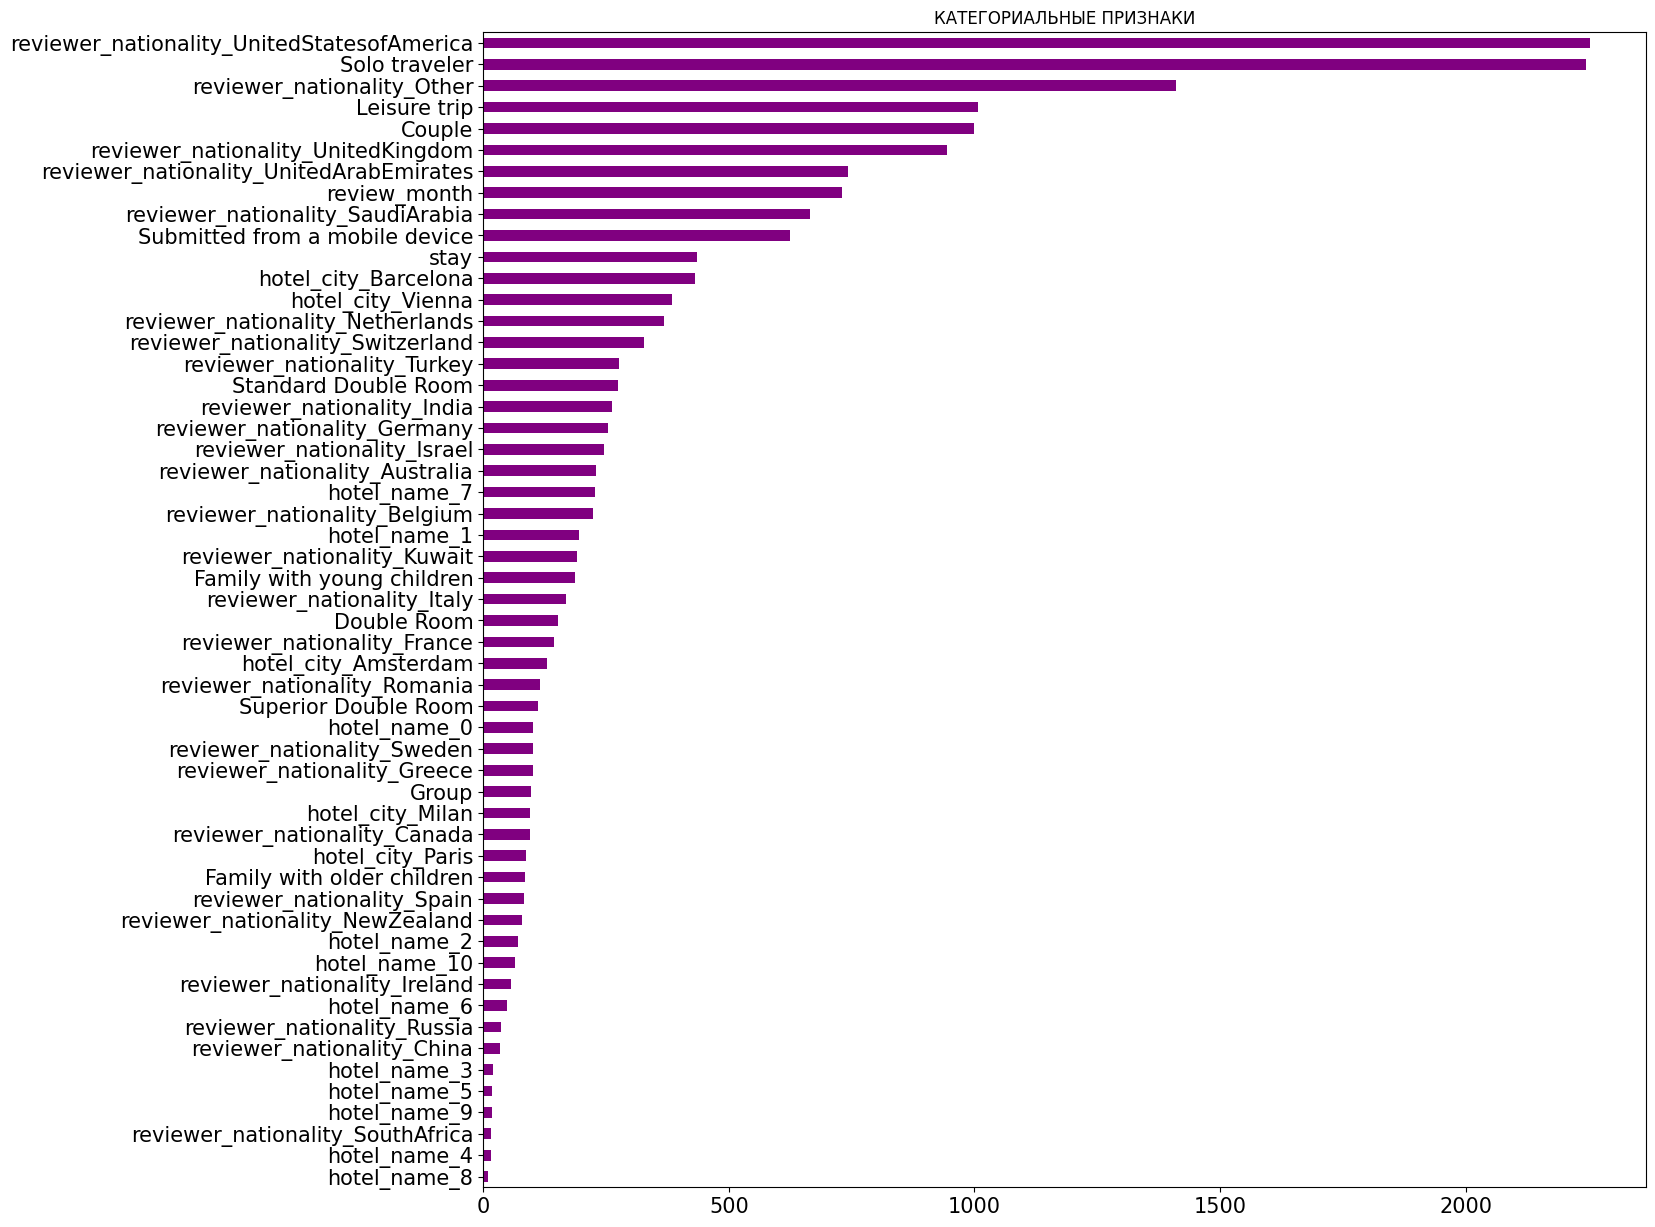

In [135]:
# Хи-квадрат для категориальных признаков 
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)

fig, ax = plt.subplots(figsize=(15, 15))
imp_cat.plot(kind = 'barh', color='purple', title='КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ', fontsize=15)
;

In [136]:
# удалим колонки с низким рейтингом
data_copy.drop(['hotel_name_3', 'hotel_name_4', 'hotel_name_5','hotel_name_8', 'hotel_name_9', 'reviewer_nationality_SouthAfrica'],axis=1, inplace=True)

''

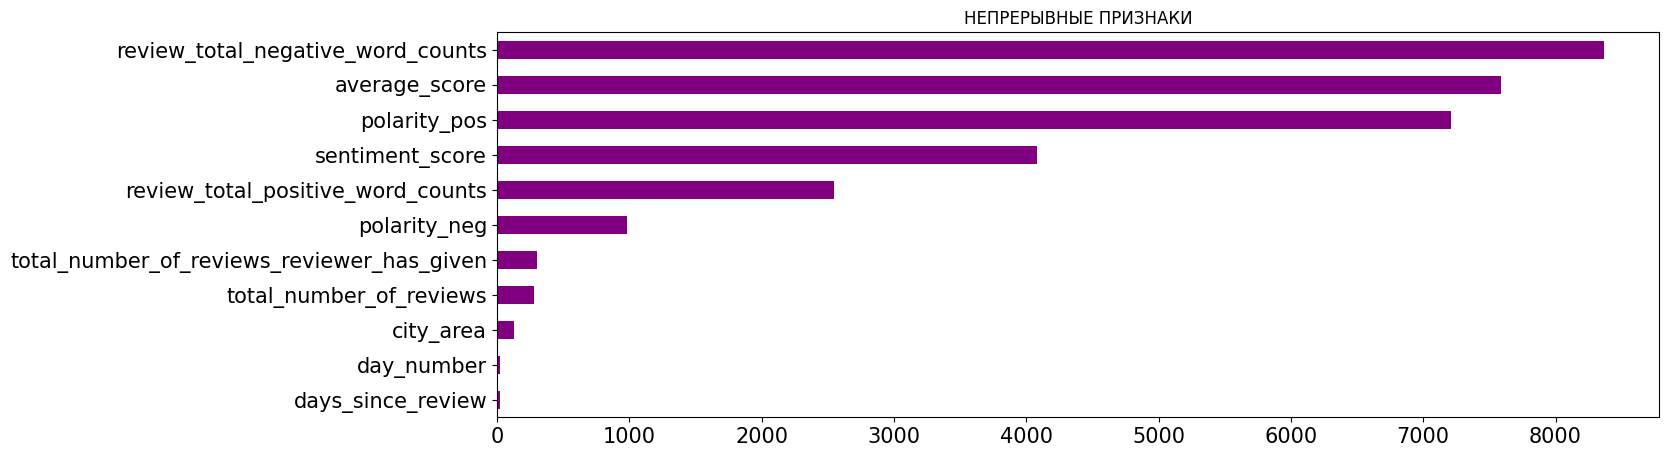

In [137]:
# ANOVA для непрерывных признаков 
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)

fig, ax = plt.subplots(figsize=(15, 5))
imp_num.plot(kind = 'barh', color='purple', title='НЕПРЕРЫВНЫЕ ПРИЗНАКИ', fontsize=15)
;

In [138]:
# удалим колонки с низким рейтингом
data_copy.drop(['day_number', 'days_since_review'],axis=1, inplace=True)

# 5. Обучение модели и получение предсказания

In [139]:
# Выделим тестовую часть
train_data = data_copy.query('sample == 1').drop(['sample'], axis=1)
test_data = data_copy.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

# Разобьем тестовые данные, выделим 20% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создадим модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучим модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке
# Предсказанные значения запишем в переменную y_pred
y_pred = model.predict(X_test)

# Сравним предсказанные значения (y_pred) с реальными (y_test) по метрике MAPE
# Данная метрика показывает среднее отклонение предсказанных значений от фактических в процентах
def MAPE(y_test, y_pred): 
    y_true, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test))*100
print('MAPE:', (MAPE(y_test, y_pred)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


MAPE: 12.939624331480251


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


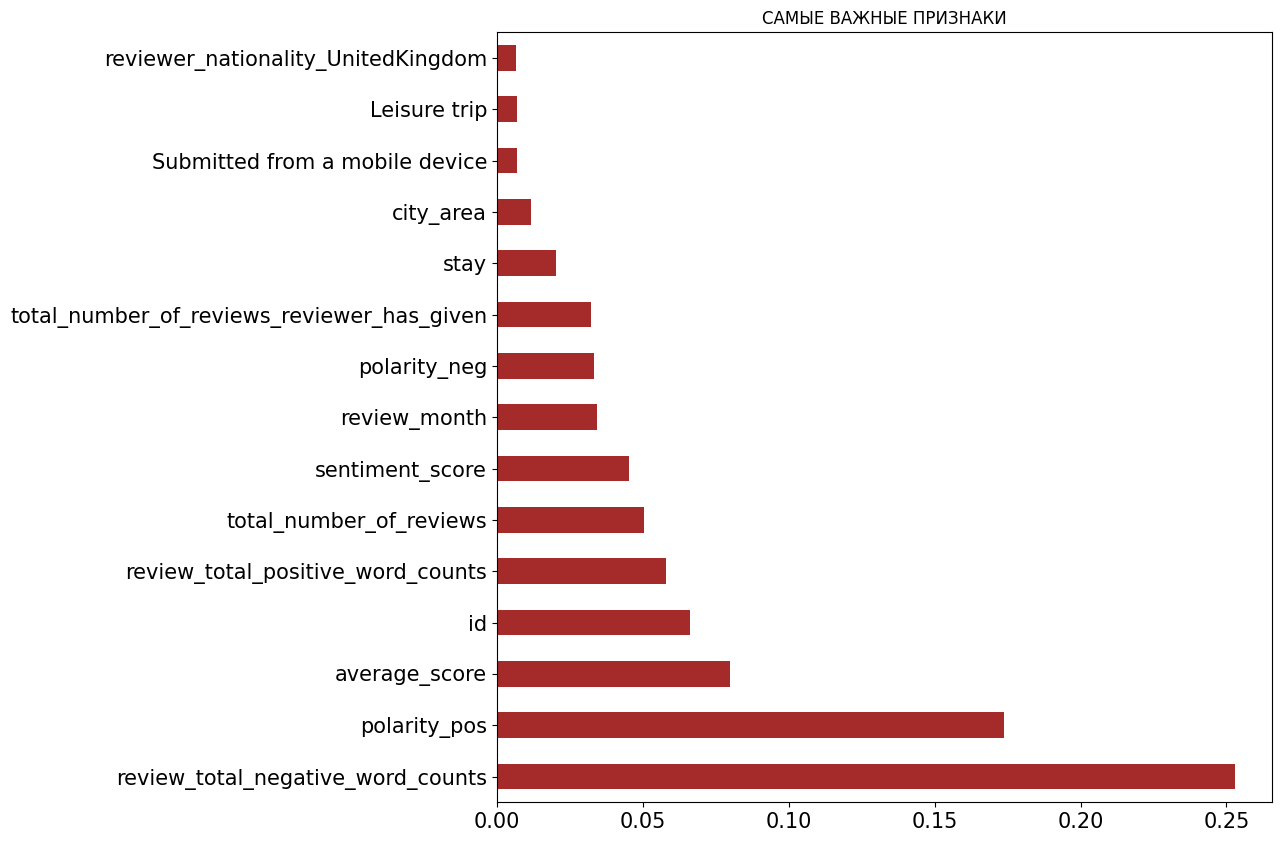

In [140]:
# выведем самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color='brown', title='САМЫЕ ВАЖНЫЕ ПРИЗНАКИ', fontsize=15);

In [141]:
# Выполним предсказание 
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission
#  сохраним результат
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


,reviewer_score,id
0,8.423,488440
1,7.075,274649
2,8.327,374688
3,9.462,404352
4,9.414,451596
5,7.919,302161
6,8.178,317079
7,7.367,13963
8,8.510,159785
9,6.618,195089


In [142]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt